In [1]:
# This is to ensure that the IERS data is not downloaded automatically by Astropy, which can cause cache issues with muli-processing
from astropy.utils import iers
iers.conf.auto_download = False
iers.conf.iers_degraded_accuracy = "warn"

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import sys
sys.path.append('../')
import h5py
import pandas as pd
import os
import numpy as np
import pylab as plt
from glob import glob
from tqdm import tqdm
import seaborn as sns
from scipy.stats import ncx2
from pesummary.gw.conversions.spins import spin_angles
from GWFish.modules.detection import Network
from GWFish.modules.fishermatrix import compute_network_errors
import GWFish.modules as gwf_mods
import pathlib
from utils import get_detected_SNRs, load_results_from_h5

## Get injection data SNRs

In [5]:
#base_dir = '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/'
base_dir = '/home/divyajyoti.nln/Cardiff_University/Next_gen_detectability/A-sharp-study/'
#inj_data_file = os.path.join(base_dir, 'SNR_output_files_XPHM', 'BBH', 
#                             'CE4020ET123_CoBA10_SNR_5_pop_PLP_spin_prec_fref_5_z_MDlow_zp_1.54_zmax_10_lmrd_22_365_days_corrected_td_SNR_data.h5')
inj_data_file = os.path.join(base_dir, 'SNR_output_files_XPHM', 'BBH', 
                             'LHI_SNR_4_pop_set2_PLP_spin_prec_fref_10_z_MDhigh_zp_2.53_zmax_10_lmrd_22_365_days_corrected_td_SNR_data.h5')

In [6]:
inj_data = load_results_from_h5(inj_data_file)

In [7]:
pd.DataFrame(inj_data['results'])

,PSD_H1,PSD_I1,PSD_L1,SNR_H1,SNR_I1,SNR_L1,SNR_mf_from_opt_H1,SNR_mf_from_opt_I1,SNR_mf_from_opt_L1,SNR_mf_from_opt_network,...,spin2x,spin2y,spin2z,srcmass1,srcmass2,srcmchirp,srcmtotal,theta_jn,time_interval,trigger_time
0,ASharp,ASharp,ASharp,2.046714,2.992601,1.724880,1.909150,1.825269,2.419134,3.581713,...,-0.305655,-0.438337,-0.350138,12.073226,6.640351,7.726401,18.713577,1.764728,689.528318,1.893025e+09
1,ASharp,ASharp,ASharp,2.130556,1.916250,1.702208,4.843387,2.995123,3.179524,6.522157,...,0.428039,0.340088,-0.232434,11.734010,5.378756,6.814169,17.112766,0.687272,495.149227,1.893025e+09
2,ASharp,ASharp,ASharp,1.648880,1.218830,0.884230,2.056741,2.266896,0.384359,3.084920,...,0.510544,-0.322068,0.613079,19.171528,14.664900,14.570840,33.836428,1.633216,94.107540,1.893025e+09
3,ASharp,ASharp,ASharp,0.234488,2.164269,1.739105,2.160931,1.638601,1.283594,3.000375,...,-0.092018,-0.633674,0.195932,8.406623,7.479193,6.900553,15.885817,1.075617,512.154752,1.893026e+09
4,ASharp,ASharp,ASharp,0.899945,1.687855,0.993788,1.311585,2.490546,2.222515,3.586453,...,0.344128,-0.496620,0.431833,7.251471,4.848143,5.140988,12.099614,2.077659,1912.531223,1.893028e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49081,ASharp,ASharp,ASharp,6.474466,8.995168,9.519423,7.972738,8.399075,8.527901,14.381729,...,-0.490905,-0.591673,-0.439727,42.339752,17.184381,23.024527,59.524133,0.756809,313.029402,1.924785e+09
49082,ASharp,ASharp,ASharp,2.901329,4.186204,3.629015,3.969402,4.056337,2.033545,6.028708,...,0.251581,0.921872,-0.229559,9.950577,6.978728,7.231808,16.929306,2.455633,476.198135,1.924786e+09
49083,ASharp,ASharp,ASharp,5.550027,3.228721,5.332332,5.345523,3.807821,4.892676,8.186110,...,-0.448679,-0.035181,-0.348600,11.196213,9.209417,8.831449,20.405630,1.969202,623.342704,1.924786e+09
49084,ASharp,ASharp,ASharp,2.106240,2.833102,2.937745,2.132074,1.609404,1.687190,3.159514,...,0.390088,-0.456293,0.026440,6.621968,6.585654,5.748925,13.207622,2.546684,539.796875,1.924787e+09


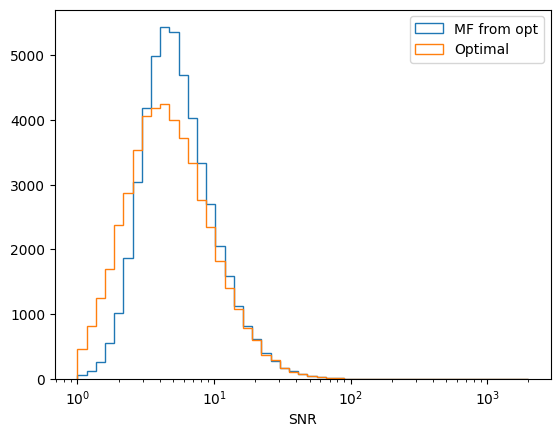

In [9]:
plt.hist(inj_data['results']['SNR_mf_from_opt_network'], bins=np.logspace(0,3.3,50), histtype=u'step', label='MF from opt');
#plt.hist(inj_data['results']['SNR_mf_network'], bins=np.logspace(0,3.3,50), histtype=u'step', label='MF');
plt.hist(inj_data['results']['SNR_network'], bins=np.logspace(0,3.3,50), histtype=u'step', label='Optimal');
plt.xlabel('SNR')
plt.legend()
plt.xscale('log')

### Get detected

In [10]:
inj_data['detected'] = get_detected_SNRs(inj_data['results'], method='network', 
                                         snr_type='opt', network_threshold=10)

['SNR_H1', 'SNR_I1', 'SNR_L1', 'SNR_network']


### Detected percentage

In [11]:
n_total = len(inj_data['results']['redshift'])
#n_detected = len(inj_data['detected_mf_from_opt']['redshift'])
n_detected = len(inj_data['detected']['redshift'])

print('Total =', n_total)
print('detected =', n_detected, '=', round(n_detected*100/n_total, 1), '%')

Total = 49086
detected = 7213 = 14.7 %


### Choose n_events from detected as injection parameters

In [12]:
#n_events = 4000
n_events = len(inj_data['detected']['redshift'])
inj_data['selected_n_events'] = inj_data['detected'].sample(n_events, random_state=128).reset_index().rename(columns={'index': 'old_index'})
#inj_data['selected_n_events'].insert(5, 'SNR_ET', np.sqrt(inj_data['selected_n_events']['SNR_E1']**2 + inj_data['selected_n_events']['SNR_E2']**2 + inj_data['selected_n_events']['SNR_E3']**2))
#inj_data['selected_n_events'] = inj_data['detected_mf'].iloc[:n_events]

Text(0.5, 0, 'z')

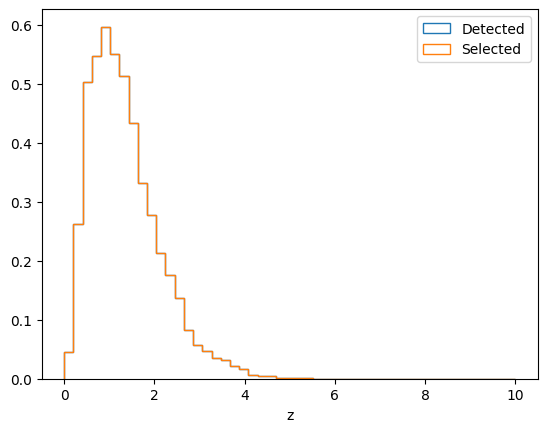

In [13]:
plt.hist(inj_data['detected']['redshift'], density=True, histtype=u'step', bins=np.linspace(0,10,50), 
         label='Detected')
plt.hist(inj_data['selected_n_events']['redshift'], density=True, histtype=u'step', 
         bins=np.linspace(0,10,50), label='Selected');
plt.legend()
plt.xlabel('z')

In [14]:
len(inj_data['selected_n_events']['redshift'])

7213

## FM analysis with GWFish

In [15]:
inj_data['selected_n_events'].keys()

Index(['old_index', 'PSD_H1', 'PSD_I1', 'PSD_L1', 'SNR_H1', 'SNR_I1', 'SNR_L1',
       'SNR_mf_from_opt_H1', 'SNR_mf_from_opt_I1', 'SNR_mf_from_opt_L1',
       'SNR_mf_from_opt_network', 'SNR_network', 'approximant',
       'chi_1_in_plane', 'chi_2_in_plane', 'chi_eff', 'chi_p', 'coa_phase',
       'cos_spin1_polar', 'cos_spin2_polar', 'dec', 'delta_f', 'distance',
       'eta', 'f_final', 'f_lower', 'f_ref', 'inclination', 'mass1', 'mass2',
       'mchirp', 'mtotal', 'phi_12', 'phi_jl', 'polarization', 'q', 'ra',
       'redshift', 'spin1_a', 'spin1_azimuthal', 'spin1_polar', 'spin1x',
       'spin1y', 'spin1z', 'spin2_a', 'spin2_azimuthal', 'spin2_polar',
       'spin2x', 'spin2y', 'spin2z', 'srcmass1', 'srcmass2', 'srcmchirp',
       'srcmtotal', 'theta_jn', 'time_interval', 'trigger_time'],
      dtype='object')

In [16]:
pycbc_to_pesummary_map = {
    'mchirp': 'chirp_mass',
    'q': 'mass_ratio',
    'distance': 'luminosity_distance',
    'theta_jn': 'theta_jn',
    'ra': 'ra',
    'dec': 'dec',
    'polarization': 'psi',
    'trigger_time': 'geocent_time',
    'coa_phase': 'phase',
    'spin1_a': 'a_1',
    'spin2_a': 'a_2',
    'spin1_polar': 'tilt_1',
    'spin2_polar':'tilt_2',
    'phi_12': 'phi_12',
    'phi_jl': 'phi_jl',
    'mass1': 'mass_1',
    'mass2': 'mass_2'
}
#gwfish_det_dict = {'L1':'L', 'H1':'H', 'I1':'IN'}

In [17]:
gwfish_input_data = {pycbc_to_pesummary_map[key]:inj_data['selected_n_events'][key] for key in pycbc_to_pesummary_map.keys() if key != 'q'}
gwfish_input_data = pd.DataFrame(gwfish_input_data)
gwfish_input_data['mass_ratio'] = 1/inj_data['selected_n_events']['q']

In [18]:
gwfish_input_data

,chirp_mass,luminosity_distance,theta_jn,ra,dec,psi,geocent_time,phase,a_1,a_2,tilt_1,tilt_2,phi_12,phi_jl,mass_1,mass_2,mass_ratio
0,36.238607,4661.342390,2.282257,3.830244,-0.270066,2.090553,1.907494e+09,3.852046,0.140253,0.864727,1.617414,0.960720,4.598772,4.100434,46.420554,37.415590,0.806013
1,56.957547,5006.982371,1.146831,1.775359,-1.022899,2.502867,1.902722e+09,4.742571,0.154820,0.898338,1.943484,0.750926,4.871134,0.720342,68.585206,62.441779,0.910426
2,10.026041,3417.044961,0.932260,4.198183,-0.451535,0.913910,1.915560e+09,2.258751,0.770248,0.678622,1.521123,1.992401,2.407345,4.877920,12.420779,10.690799,0.860719
3,10.119328,3964.148938,2.404520,2.132468,1.420860,2.614628,1.916166e+09,0.519373,0.223778,0.177250,2.791578,1.451803,3.131548,4.636024,15.615554,8.794664,0.563199
4,55.711032,6491.391768,1.779024,0.230554,-0.627967,1.220862,1.909716e+09,1.712320,0.131961,0.144974,0.735589,1.483387,5.044083,3.104851,65.894086,62.161543,0.943355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7208,8.397812,5168.685092,0.688735,0.258067,-0.677566,1.111684,1.895567e+09,3.877779,0.527277,0.383095,1.509174,1.498941,0.024939,6.282095,19.226641,5.238705,0.272471
7209,60.711449,8725.648855,1.448009,1.073743,0.426906,2.981623,1.902083e+09,0.314293,0.568607,0.656856,1.303854,1.173214,3.602991,0.593846,79.448223,61.419120,0.773071
7210,31.477840,5353.020736,1.079200,1.459611,-0.289978,1.630296,1.903377e+09,4.610547,0.182528,0.076907,1.039114,2.131881,5.400124,4.328641,36.673049,35.652676,0.972176
7211,7.742701,1117.815159,1.942732,4.872602,-0.847909,2.101190,1.917522e+09,1.702165,0.292395,0.962313,1.229409,0.130239,1.791539,5.640445,10.742161,7.414353,0.690211


In [19]:
file_str = inj_data_file.split('/')[-1]
for repl_tup in [('_pop_PLP', '_PLP'), 
                 ('_SNR', ''), 
                 ('_spin_prec', ''), 
                 ('_fref_5', ''), 
                 ('_365_days_corrected_td_data.h5', '')]:
    file_str = file_str.replace(repl_tup[0], repl_tup[1])
file_str

'LHI_4_pop_set2_PLP_fref_10_z_MDhigh_zp_2.53_zmax_10_lmrd_22'

In [20]:
if 'set' in file_str:
    set_num = file_str.split('set')[-1].split('_')[0]
    file_str = file_str.replace('pop_', '').replace('set'+set_num+'_', '').replace('PLP_', 'PLP_set'+set_num+'_')
file_str

'LHI_4_PLP_set2_fref_10_z_MDhigh_zp_2.53_zmax_10_lmrd_22'

In [21]:
if 'CE4020ET123' in file_str:
    detectors = ['CE1', 'CE2', 'ET']
elif 'LHI' in file_str:
    detectors = ['A_sharp_L', 'A_sharp_H', 'A_sharp_IN']
matrix_file_names = f'{file_str}_no_spins_{n_events}_events_pop_from_XPHM_det10_opt_netw'
#matrix_file_names = f'LHI_5_PLP_z_MDlow_zp_1.54_zmax_10_lmrd_22_no_spins_{n_events}_events_pop_from_XPHM_det10_opt'
print(detectors)
print(matrix_file_names)

['A_sharp_L', 'A_sharp_H', 'A_sharp_IN']
LHI_4_PLP_set2_fref_10_z_MDhigh_zp_2.53_zmax_10_lmrd_22_no_spins_7213_events_pop_from_XPHM_det10_opt_netw


### Without parallelization

In [19]:
results = {'detected_idxs':[], 
           'netw_snrs':[], 
           'errors':[],
           'sky_locs':[]}
fisher_params = ['chirp_mass', 'mass_ratio', 'luminosity_distance', 'theta_jn', 'phase', 'geocent_time', 'ra', 'dec', 'psi']
network = gwf_mods.detection.Network(detector_ids = detectors, detection_SNR = (0., 5.), config=pathlib.Path('detectors.yaml'))
#for event_num in tqdm(range(len(inj_data['selected_n_events']))):
results['detected_idxs'], results['netw_snrs'], results['errors'], results['sky_locs'] = compute_network_errors(
    network=network, 
    parameter_values=gwfish_input_data,
    fisher_parameters=fisher_params, 
    f_ref=inj_data['selected_n_events']['f_ref'][0], 
    waveform_model='IMRPhenomXPHM',
    save_matrices=True,
    save_matrices_path=pathlib.Path(os.path.join(base_dir, 
                                                 'GWFish_analysis', 
                                                 'BBH',
                                                 'Fisher_matrices')),
    matrix_naming_postfix=matrix_file_names
)

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 4/5000 [00:05<1:52:56,  1.36s/it]


KeyboardInterrupt: 

### With parallelization

In [22]:
nprocs = 16
from gwfish_functions import parallel_compute_network_errors, combine_and_archive_fisher_matrices

In [23]:
fisher_params = ['chirp_mass', 'mass_ratio', 'luminosity_distance', 'theta_jn', 'phase', 'geocent_time', 'ra', 'dec', 'psi']
network = gwf_mods.detection.Network(detector_ids = detectors, detection_SNR = (0., 1.), config=pathlib.Path('detectors.yaml'))
results = {}
results['detected_idxs'], results['netw_snrs'], results['errors'], results['sky_locs'] = (
    parallel_compute_network_errors(
        network=network,
        gwfish_input_data=gwfish_input_data,
        fisher_params=fisher_params,
        f_ref=inj_data['selected_n_events']['f_ref'][0],
        base_dir=base_dir,
        matrix_file_names=matrix_file_names,
        nproc=nprocs
    )
)

100%|██████████| 451/451 [58:49<00:00,  7.83s/it]


In [24]:
combine_and_archive_fisher_matrices(
    base_dir=os.path.join(base_dir, 'GWFish_analysis', 'BBH', 'Fisher_matrices'),
    matrix_file_prefix=f'fisher_matrices_{matrix_file_names}',
    n_chunks=nprocs,
    output_file=os.path.join(base_dir, 'GWFish_analysis', 'BBH', 'Fisher_matrices', f'fisher_matrices_{matrix_file_names}.npy')
)

combine_and_archive_fisher_matrices(
    base_dir=os.path.join(base_dir, 'GWFish_analysis', 'BBH', 'Fisher_matrices'),
    matrix_file_prefix=f'inv_fisher_matrices_{matrix_file_names}',
    n_chunks=nprocs,
    output_file=os.path.join(base_dir, 'GWFish_analysis', 'BBH', 'Fisher_matrices', f'inv_fisher_matrices_{matrix_file_names}.npy')
)

Combined Fisher matrices saved to /home/divyajyoti.nln/Cardiff_University/Next_gen_detectability/A-sharp-study/GWFish_analysis/BBH/Fisher_matrices/fisher_matrices_LHI_4_PLP_set2_fref_10_z_MDhigh_zp_2.53_zmax_10_lmrd_22_no_spins_7213_events_pop_from_XPHM_det10_opt_netw.npy
Moved 16 chunked Fisher matrix files to /home/divyajyoti.nln/Cardiff_University/Next_gen_detectability/A-sharp-study/GWFish_analysis/BBH/Fisher_matrices/chunks
Combined Fisher matrices saved to /home/divyajyoti.nln/Cardiff_University/Next_gen_detectability/A-sharp-study/GWFish_analysis/BBH/Fisher_matrices/inv_fisher_matrices_LHI_4_PLP_set2_fref_10_z_MDhigh_zp_2.53_zmax_10_lmrd_22_no_spins_7213_events_pop_from_XPHM_det10_opt_netw.npy
Moved 16 chunked Fisher matrix files to /home/divyajyoti.nln/Cardiff_University/Next_gen_detectability/A-sharp-study/GWFish_analysis/BBH/Fisher_matrices/chunks


In [25]:
results['errors'] = pd.DataFrame(results['errors'], columns=fisher_params)
results['errors']

,chirp_mass,mass_ratio,luminosity_distance,theta_jn,phase,geocent_time,ra,dec,psi
0,0.015551,0.029311,980.065715,0.194982,1.171893,0.000316,0.008360,0.026503,0.503069
1,0.013981,0.033307,629.690840,0.118386,0.271096,0.000313,0.016501,0.021014,0.104189
2,0.004476,0.015093,816.436977,0.184920,0.905283,0.001066,0.076854,0.113504,0.266318
3,0.003450,0.011295,1994.539679,0.665538,4.480930,0.000243,0.048179,0.025889,2.292049
4,0.037605,0.134148,1283.757833,0.302146,0.321878,0.000766,0.014378,0.079300,0.349965
...,...,...,...,...,...,...,...,...,...
7208,0.001093,0.002523,662.156077,0.170805,1.061146,0.000284,0.038546,0.017812,0.514114
7209,0.003021,0.036971,646.892572,0.058394,0.177022,0.000364,0.043916,0.036071,0.086398
7210,0.011229,0.153645,836.817642,0.142585,0.338058,0.001181,0.095038,0.116444,0.163664
7211,0.000153,0.002398,76.699167,0.079593,0.194465,0.000045,0.011333,0.007502,0.096205


### Add original parameters to the results dict

In [26]:
results['all_inj_params_original'] = inj_data['selected_n_events']
results['all_inj_params_original'].loc[:,'log_distance'] = np.log(results['all_inj_params_original']['distance'])
results['all_inj_params_original'].loc[:, 'inv_q'] = 1/results['all_inj_params_original']['q']

In [27]:
results['deriv_variables_in_order'] = np.array(results['errors'].keys(), dtype=h5py.string_dtype(encoding='utf-8'))
results['deriv_variables_in_order']

array(['chirp_mass', 'mass_ratio', 'luminosity_distance', 'theta_jn',
       'phase', 'geocent_time', 'ra', 'dec', 'psi'], dtype=object)

In [28]:
pesummary_to_pycbc_map = {
    'chirp_mass':'mchirp',
    'mass_ratio':'inv_q',
    'luminosity_distance':'distance',
    'theta_jn':'theta_jn',
    'phase':'coa_phase',
    'geocent_time':'trigger_time',
    'ra':'ra',
    'dec':'dec',
    'psi':'polarization'
}

In [29]:
results['inj_params'] = pd.DataFrame({key:results['all_inj_params_original'][pesummary_to_pycbc_map[key]] for key in results['deriv_variables_in_order']})
results['inj_params']

,chirp_mass,mass_ratio,luminosity_distance,theta_jn,phase,geocent_time,ra,dec,psi
0,36.238607,0.806013,4661.342390,2.282257,3.852046,1.907494e+09,3.830244,-0.270066,2.090553
1,56.957547,0.910426,5006.982371,1.146831,4.742571,1.902722e+09,1.775359,-1.022899,2.502867
2,10.026041,0.860719,3417.044961,0.932260,2.258751,1.915560e+09,4.198183,-0.451535,0.913910
3,10.119328,0.563199,3964.148938,2.404520,0.519373,1.916166e+09,2.132468,1.420860,2.614628
4,55.711032,0.943355,6491.391768,1.779024,1.712320,1.909716e+09,0.230554,-0.627967,1.220862
...,...,...,...,...,...,...,...,...,...
7208,8.397812,0.272471,5168.685092,0.688735,3.877779,1.895567e+09,0.258067,-0.677566,1.111684
7209,60.711449,0.773071,8725.648855,1.448009,0.314293,1.902083e+09,1.073743,0.426906,2.981623
7210,31.477840,0.972176,5353.020736,1.079200,4.610547,1.903377e+09,1.459611,-0.289978,1.630296
7211,7.742701,0.690211,1117.815159,1.942732,1.702165,1.917522e+09,4.872602,-0.847909,2.101190


In [30]:
load_inv_matrices = np.load(os.path.join(base_dir, 'GWFish_analysis', 'BBH', 'Fisher_matrices', 
                                         f'inv_fisher_matrices_{matrix_file_names}.npy'))

In [31]:
len(load_inv_matrices)

7213

In [32]:
results['cov'] = load_inv_matrices

## Sanity checks

### Check if cov matrices are positive-definite

In [33]:
failed = []
for event in range(len(results['all_inj_params_original'])):
    cov = load_inv_matrices[event]  # the covariance matrix
    try:
        np.linalg.cholesky(cov)
    except np.linalg.LinAlgError:
        failed.append(event)

In [34]:
failed

[114, 1467, 2458, 3858, 4289]

In [35]:
failed_dict = {}
if len(failed) !=0:
    failed_dict['inj_params'] = results['inj_params'].loc[failed]
    failed_dict['all_inj_params_original'] = results['all_inj_params_original'].loc[failed]

In [36]:
failed_dict['inj_params']

,chirp_mass,mass_ratio,luminosity_distance,theta_jn,phase,geocent_time,ra,dec,psi
114,17.011456,0.680766,9084.996844,0.075934,0.514336,1.917660e+09,6.054933,0.522660,3.119171
1467,92.740170,0.918858,24513.705171,3.120715,1.883229,1.916465e+09,2.756380,-0.514063,2.619049
2458,61.942175,0.846929,15250.583385,3.081195,1.834705,1.923775e+09,1.808324,0.433874,2.210688
3858,101.444968,0.700837,25209.187765,2.948154,3.447323,1.905924e+09,0.146752,-0.859415,2.812250
4289,13.193214,0.840025,10424.987537,3.090125,3.545902,1.906909e+09,1.392091,0.928343,2.021384


In [37]:
print(len(results['inj_params']))

7213


In [38]:
results.keys()

dict_keys(['detected_idxs', 'netw_snrs', 'errors', 'sky_locs', 'all_inj_params_original', 'deriv_variables_in_order', 'inj_params', 'cov'])

In [39]:
[(key, type(results[key])) for key in results.keys()]

[('detected_idxs', numpy.ndarray),
 ('netw_snrs', numpy.ndarray),
 ('errors', pandas.core.frame.DataFrame),
 ('sky_locs', numpy.ndarray),
 ('all_inj_params_original', pandas.core.frame.DataFrame),
 ('deriv_variables_in_order', numpy.ndarray),
 ('inj_params', pandas.core.frame.DataFrame),
 ('cov', numpy.ndarray)]

In [40]:
results_updated = {}
for key in results.keys():
    if key == 'detected_idxs':
        continue
    if key == 'deriv_variables_in_order':
        results_updated[key] = results[key]
    else:
        if len(failed) == 0:
            print("No failed events")
            results_updated[key] = results[key]
        else:
            if isinstance(results[key], pd.DataFrame):
                results_updated[key] = results[key].drop(index=failed)
            elif isinstance(results[key], np.ndarray):
                results_updated[key] = np.array([results[key][i] for i in range(len(results[key])) if i not in failed])

In [41]:
print(len(results_updated['inj_params']))

7208


### Check for positive-definite again

In [42]:
failed2 = []
for event in range(len(results_updated['all_inj_params_original'])):
    cov = results_updated['cov'][event]  # the covariance matrix
    try:
        np.linalg.cholesky(cov)
    except np.linalg.LinAlgError:
        failed2.append(event)

In [43]:
failed2

[]

In [44]:
results.keys()

dict_keys(['detected_idxs', 'netw_snrs', 'errors', 'sky_locs', 'all_inj_params_original', 'deriv_variables_in_order', 'inj_params', 'cov'])

### DL errors are reasonable

Text(0.5, 0, '$\\Delta D_L / D_L$')

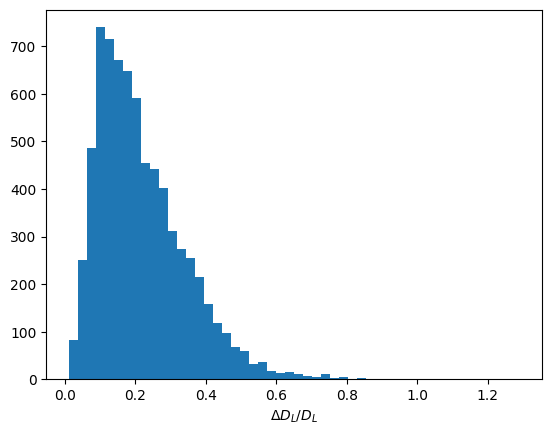

In [45]:
plt.hist(results_updated['errors']['luminosity_distance']/results_updated['all_inj_params_original']['distance'], bins=50);
plt.xlabel('$\Delta D_L / D_L$')

Text(0.5, 0, 'Network SNR')

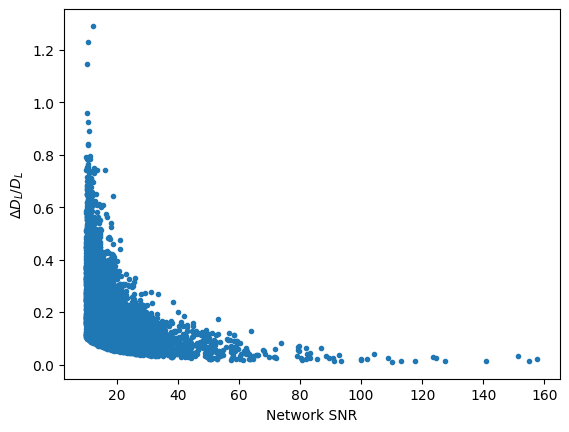

In [46]:
plt.plot(results_updated['netw_snrs'], 
         results_updated['errors']['luminosity_distance']/results_updated['all_inj_params_original']['distance'], '.')
plt.ylabel('$\Delta D_L / D_L$')
plt.xlabel('Network SNR')

### Check the recomibing has not messed up matrix orders

In [47]:
dl_idx = list(results_updated['errors'].keys()).index('luminosity_distance')
dl_idx

2

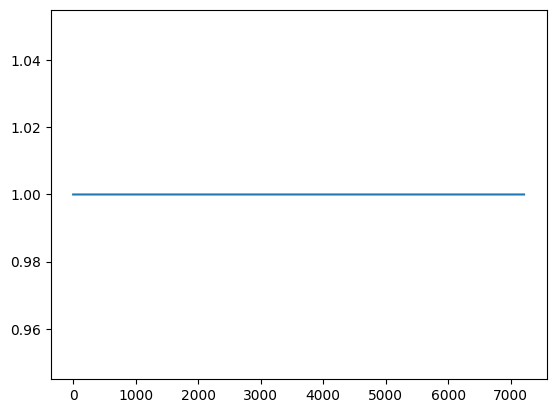

In [48]:
dl_errs_from_covs = [np.sqrt(cov[dl_idx, dl_idx]) for cov in results_updated['cov']]
plt.plot(results_updated['errors']['luminosity_distance']/dl_errs_from_covs)

### Check SNRs are matching with injected

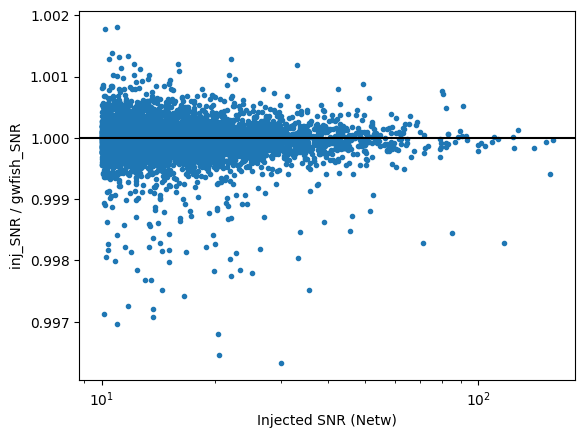

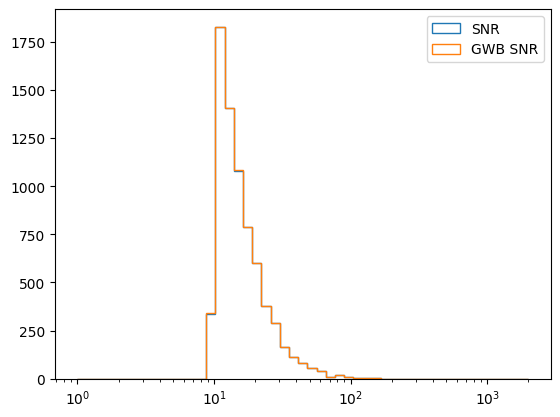

In [49]:
inj_snrs = results_updated['all_inj_params_original']['SNR_network']
gwfish_snrs = results_updated['netw_snrs']

plt.figure()
plt.plot(inj_snrs, inj_snrs/gwfish_snrs, '.')
plt.xlabel('Injected SNR (Netw)')
plt.ylabel('inj_SNR / gwfish_SNR')
plt.axhline(1, c='k')
plt.xscale('log')

plt.figure()
plt.hist(inj_snrs, bins=np.logspace(0,3.3,50), histtype=u'step', label='SNR');
plt.hist(gwfish_snrs, bins=np.logspace(0,3.3,50), histtype=u'step', label='GWB SNR');
plt.legend()
plt.xscale('log')

## Save to h5 file

### Write to file

In [50]:
print(results_updated.keys())
[type(results_updated[key]) for key in results_updated.keys()]

dict_keys(['netw_snrs', 'errors', 'sky_locs', 'all_inj_params_original', 'deriv_variables_in_order', 'inj_params', 'cov'])


[numpy.ndarray,
 pandas.core.frame.DataFrame,
 numpy.ndarray,
 pandas.core.frame.DataFrame,
 numpy.ndarray,
 pandas.core.frame.DataFrame,
 numpy.ndarray]

In [51]:
inj_data_file.split('/')[-1]

'LHI_SNR_4_pop_set2_PLP_spin_prec_fref_10_z_MDhigh_zp_2.53_zmax_10_lmrd_22_365_days_corrected_td_SNR_data.h5'

In [52]:
file_str

'LHI_4_PLP_set2_fref_10_z_MDhigh_zp_2.53_zmax_10_lmrd_22'

In [53]:
results_file = os.path.join(base_dir, 'GWFish_analysis', 'BBH', 'Errors',
                            f'{file_str}_no_spins_{len(results_updated["errors"])}_events_pop_from_XPHM_det10_opt_netw.h5')
#results_file = os.path.join(base_dir, 'GWFish_analysis', 'BBH', 'Errors',
#                            f'LHI_Asharp_5_PLP_z_MDlow_zp_1.54_zmax_10_lmrd_22_no_spins_{len(results_updated["errors"])}_events_365_days_pop_from_XPHM_det10.h5')
results_file = results_file.replace('_fref_10', '').replace('LHI_', 'LHI_Asharp_')
results_file

'/home/divyajyoti.nln/Cardiff_University/Next_gen_detectability/A-sharp-study/GWFish_analysis/BBH/Errors/LHI_Asharp_4_PLP_set2_z_MDhigh_zp_2.53_zmax_10_lmrd_22_no_spins_7208_events_pop_from_XPHM_det10_opt_netw.h5'

In [54]:
from utils import save_results_to_h5
save_results_to_h5(results_updated, results_file)

## Check that the file was saved properly

In [55]:
with h5py.File(results_file, 'r') as f:
    print(f.keys())
    print(f['errors'].keys())
    print(f['deriv_variables_in_order'][()])
    print(f['netw_snrs'][()])
    print(f['all_inj_params_original'].keys())

<KeysViewHDF5 ['all_inj_params_original', 'cov', 'deriv_variables_in_order', 'errors', 'inj_params', 'netw_snrs', 'sky_locs']>
<KeysViewHDF5 ['chirp_mass', 'dec', 'geocent_time', 'luminosity_distance', 'mass_ratio', 'phase', 'psi', 'ra', 'theta_jn']>
[b'chirp_mass' b'mass_ratio' b'luminosity_distance' b'theta_jn' b'phase'
 b'geocent_time' b'ra' b'dec' b'psi']
[20.28387444 27.04474351 11.18429813 ... 18.59726387 35.88035948
 13.84640082]
<KeysViewHDF5 ['PSD_H1', 'PSD_I1', 'PSD_L1', 'SNR_H1', 'SNR_I1', 'SNR_L1', 'SNR_mf_from_opt_H1', 'SNR_mf_from_opt_I1', 'SNR_mf_from_opt_L1', 'SNR_mf_from_opt_network', 'SNR_network', 'approximant', 'chi_1_in_plane', 'chi_2_in_plane', 'chi_eff', 'chi_p', 'coa_phase', 'cos_spin1_polar', 'cos_spin2_polar', 'dec', 'delta_f', 'distance', 'eta', 'f_final', 'f_lower', 'f_ref', 'inclination', 'inv_q', 'log_distance', 'mass1', 'mass2', 'mchirp', 'mtotal', 'old_index', 'phi_12', 'phi_jl', 'polarization', 'q', 'ra', 'redshift', 'spin1_a', 'spin1_azimuthal', 'spin1